In [21]:
import torch
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator
)

In [22]:
num_dim = 3

In [23]:
def simulator(theta):
    # linear guassian
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [24]:
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

In [25]:
# Check prior, return PyTorch prior
prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [26]:
# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

In [27]:
# Consistency check after making ready fo# Visualise the resultsr sbi
check_sbi_inputs(simulator, prior)

In [28]:
inference = NPE(prior=prior)

In [29]:
# Sample from the prior and corresponding simulations
num_simulations = 2000
theta = prior.sample((num_simulations,))
x = simulator(theta)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([2000, 3])
x.shape torch.Size([2000, 3])


In [30]:
# Pass the simulated data to the inference object
inference = inference.append_simulations(theta, x)

In [31]:
# Train the neural density estimator to learn correlations
density_estimator = inference.train()

 Neural network successfully converged after 103 epochs.

In [32]:
# Build posterior desitribution
posterior = inference.build_posterior(density_estimator)
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [36]:
# Take a random sample from the prior
theta_true = prior.sample((1,))
# Generate our observation from the sample
x_obs = simulator(theta_true)
print("theta_true", theta_true)
print("x_obs", x_obs)

theta_true tensor([[ 0.6018, -1.1742,  1.1485]])
x_obs tensor([[ 1.5201, -0.1034,  2.0419]])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

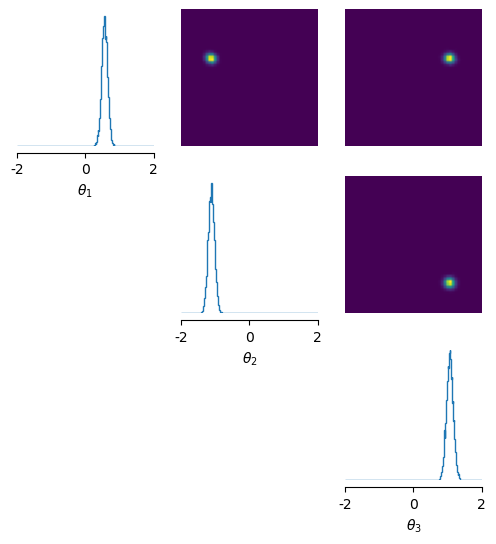

In [37]:
# Visualise the results
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             limits=[[-2,2], [-2,2], [-2,2]],
             figsize=(6,6),
             labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

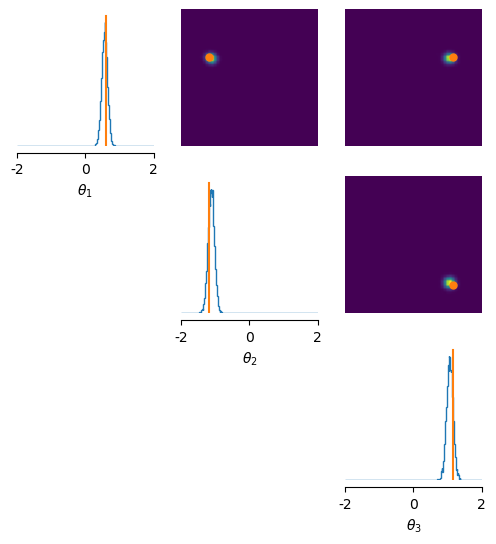

In [38]:
# We have the ground truth parameters in our example
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             points=theta_true,
             limits=[[-2,2], [-2,2], [-2,2]],
             figsize=(6,6),
             labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

In [39]:
# Obtain a sample from the posterior
theta_posterior = posterior.sample((10000,), x=x_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [40]:
# Simulate data using the posterior generated parameter
x_predictive = simulator(theta_posterior)

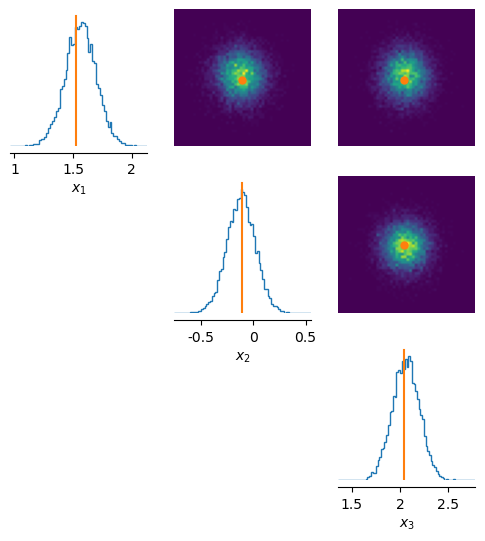

In [41]:
# Visualise the results
pairplot(x_predictive,
         points=x_obs,  # plot with x_obs as a point
         figsize=(6, 6),
         labels=[r"$x_1$", r"$x_2$", r"$x_3$"]);

In [46]:
# Compare the probabilities of different parameters under the posterior
# first sample an alternative parameter set from the prior
theta_diff = prior.sample((1,))

In [47]:
log_probability_true_theta = posterior.log_prob(theta_true, x=x_obs)
log_probability_diff_theta = posterior.log_prob(theta_diff, x=x_obs)
log_probability_samples = posterior.log_prob(samples, x=x_obs)

In [48]:
print( r'high for true theta :', log_probability_true_theta)
print( r'low for different theta :', log_probability_diff_theta)
print( r'range of posterior samples: min:', torch.min(log_probability_samples),' max :', torch.max(log_probability_samples))

high for true theta : tensor([3.6681])
low for different theta : tensor([-91.4946])
range of posterior samples: min: tensor(-6.6527)  max : tensor(4.4032)
